# Análisis de radios empleando curvas de MICP

Archivo leído exitosamente: datos_intrusion_mercurio_ts_23

Muestra: datos_intrusion_mercurio_ts_23
Radio crítico (10-75%): 266.80 nm
Saturación en punto crítico: 10.05%
Radio promedio: 98.23 nm
Radio apex: 130.08 nm
Gráfica guardada como: intrusion_mercurio.png


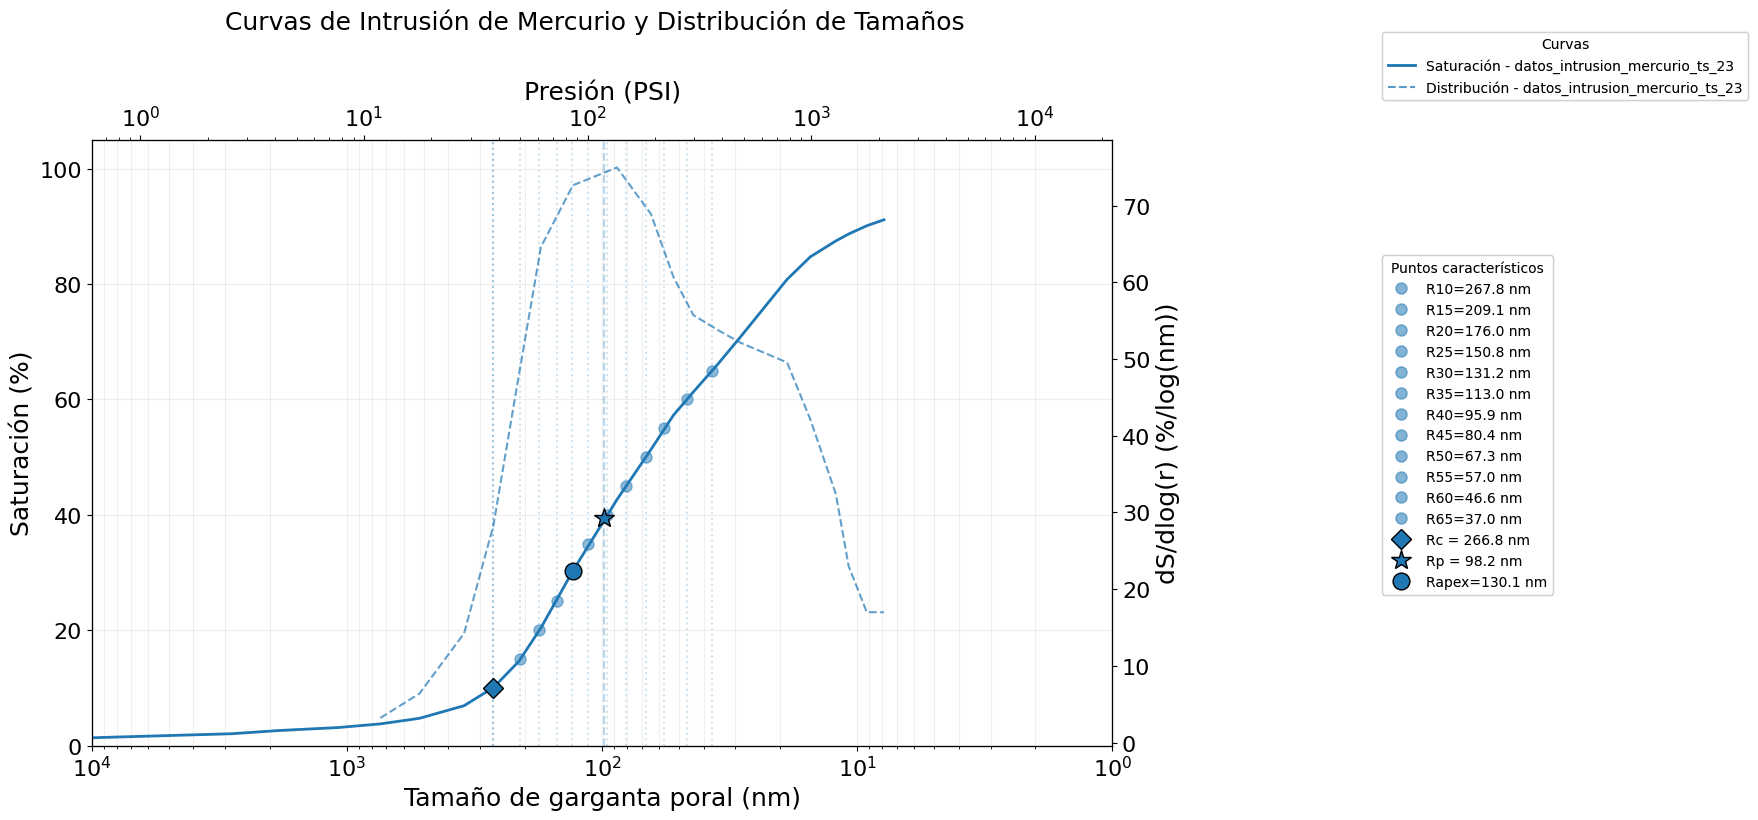

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from typing import Dict, Optional, Tuple
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy import interpolate


#Lectura de datos
data="*datos_intrusion_mercurio_ts*.xlsx"

df = pd.read_excel('datos_intrusion_mercurio_ts_23.xlsx')
df1=df

#Tamaño de fuente
f_size=16

class AnalisisIntrusionMercurio:
    def __init__(self):
        """Inicializa la clase con las variables necesarias."""
        self.datos: Dict[str, pd.DataFrame] = {}
        self.fig: Optional[plt.Figure] = None
        self.ax1: Optional[plt.Axes] = None
        self.ax2: Optional[plt.Axes] = None
        self.ax3: Optional[plt.Axes] = None
        # Constantes para la ecuación de Washburn
        self.gamma = 0.485  # N/m (tensión superficial del mercurio)
        self.theta = 140    # grados (ángulo de contacto)

    def leer_archivos(self, patron: str = data) -> None:
        """
        Lee todos los archivos Excel que coincidan con el patrón especificado.

        Args:
            patron (str): Patrón para buscar archivos Excel
        """
        archivos = glob.glob(patron)
        if not archivos:
            raise FileNotFoundError(f"No se encontraron archivos con el patrón: {patron}")

        for archivo in archivos:
            try:
                df = pd.read_excel(archivo)
                nombre_muestra = os.path.splitext(os.path.basename(archivo))[0]
                self.datos[nombre_muestra] = df
                print(f"Archivo leído exitosamente: {nombre_muestra}")
            except Exception as e:
                print(f"Error leyendo {archivo}: {e}")

    def calcular_distribucion(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calcula la distribución de tamaños de garganta porales.
        Args:
        df (pd.DataFrame): DataFrame con los datos de intrusión
············
········Returns:
············pd.DataFrame: DataFrame con la distribución calculada
········"""
        # Asegurar que los datos estén ordenados por radio de poro (descendente)
        df = df.sort_values('Radio de poro (nm)', ascending=False).copy()
        # Calcular los diferenciales
        df['dS'] = df['Saturación (%)'].diff()
        df['dlogR'] = np.log10(df['Radio de poro (nm)']).diff()
        # Calcular la distribución usando valor absoluto
        df['Distribución'] = np.abs(df['dS'] / df['dlogR'])
        # Aplicar suavizado más robusto
        window = min(7, len(df) - 1)  # Asegurar que la ventana sea menor que los datos
        if window % 2 == 0:  # Asegurar que la ventana sea impar
            window -= 1

        if window >= 3:  # Solo aplicar si hay suficientes puntos
            df['Distribución_suave'] = savgol_filter(df['Distribución'],
                                                     window_length=window,
                        polyorder=min(3, window-1))
        else:
             df['Distribución_suave'] = df['Distribución']

        return df

    def calcular_radios_caracteristicos(self, df: pd.DataFrame) -> Tuple[dict, dict]:
      df_sorted = df.sort_values('Radio de poro (nm)').copy()
      saturation = df_sorted['Saturación (%)'].values / 100
      radius_nm = df_sorted['Radio de poro (nm)'].values

      r_percentiles = {}
      saturaciones = {}
      for p in range(10, 70, 5):
        f= interpolate.interp1d(saturation, radius_nm, kind='cubic',
                                fill_value='extrapolate', bounds_error=False)
        r_percentiles[f'R{p}'] = f(p/100)
        saturaciones[f'R{p}'] = p

      return  r_percentiles, saturaciones

    def calcular_r_apex(self, df: pd.DataFrame, sat_min: float = 5.0) -> Tuple[float, float, float]:
        """
        Calcula el radio apex usando el método de saturación/presión vs saturación.

        Args:
            df (pd.DataFrame): DataFrame con los datos de MICP

        Returns:
            Tuple[float, float, float]: Radio apex (nm), saturación y ratio máximo
        """
        df_apex = df[df['Saturación (%)'] >= sat_min].copy()
        df_apex['Sat_Pressure_Ratio'] = df_apex['Saturación (%)'] / df_apex['Presión (PSI)']

        idx_max = df_apex['Sat_Pressure_Ratio'].idxmax()
        presion_apex = df_apex.loc[idx_max, 'Presión (PSI)']
        saturacion_apex = df_apex.loc[idx_max, 'Saturación (%)']
        ratio_max = df_apex.loc[idx_max, 'Sat_Pressure_Ratio']
        presion_pa = presion_apex * 6894.76
        theta_rad = np.radians(self.theta)
        r_apex = -2 * self.gamma * np.cos(theta_rad) / presion_pa
        r_apex_nm = r_apex * 1e9

        return r_apex_nm, saturacion_apex, ratio_max

    def calcular_radio_critico(self, df: pd.DataFrame) -> Tuple[float, float]:
        """
        Calcula el radio crítico usando el punto de inflexión de la curva MICP,
        considerando solo datos entre 10% y 75% de saturación.

        Args:
            df (pd.DataFrame): DataFrame con los datos de intrusión

        Returns:
            Tuple[float, float]: Radio crítico (nm) y saturación correspondiente
        """
        # Ordenar y filtrar datos por saturación entre 10% y 75%
        df_sorted = df.sort_values('Radio de poro (nm)')
        df_filtered = df_sorted[
            (df_sorted['Saturación (%)'] >= 10) &
            (df_sorted['Saturación (%)'] <= 75)
        ].copy()

        if df_filtered.empty:
            raise ValueError("No hay datos en el rango de saturación especificado (10-75%)")

        # Calcular la derivada de la saturación respecto al log del radio
        df_filtered['log_radio'] = np.log10(df_filtered['Radio de poro (nm)'])
        df_filtered['pendiente'] = np.gradient(df_filtered['Saturación (%)'],
                                             df_filtered['log_radio'])

        # Encontrar el índice del punto de inflexión
        idx_max_pendiente = df_filtered['pendiente'].idxmax()
        presion_critica = df_filtered.loc[idx_max_pendiente, 'Presión (PSI)']

        # Convertir presión de PSI a Pa
        presion_pa = presion_critica * 6894.76  # Factor de conversión PSI a Pa

        # Calcular radio crítico usando la ecuación de Washburn
        # r = 2γcos(θ)/P
        theta_rad = np.radians(self.theta)
        r_critico =- 2 * self.gamma * np.cos(theta_rad) / presion_pa

        # Convertir a nanómetros
        r_critico_nm = r_critico * 1e9

        return r_critico_nm, df_filtered.loc[idx_max_pendiente, 'Saturación (%)']

    def calcular_radio_promedio(self, df: pd.DataFrame) -> Tuple[float, float]:
        """
        Calcula el radio promedio geométrico ponderado.

        Args:
            df (pd.DataFrame): DataFrame con los datos de intrusión

        Returns:
            Tuple[float, float]: Radio promedio (nm) y saturación correspondiente
        """
        # Ordenar datos por radio de poro
        df_sorted = df.sort_values('Radio de poro (nm)')

        # Calcular incrementos de saturación
        df_sorted['delta_sat'] = df_sorted['Saturación (%)'].diff()

        # Calcular pesos (w = ai/at)
        total_sat = df_sorted['delta_sat'].abs().sum()
        df_sorted['peso'] = df_sorted['delta_sat'].abs() / total_sat

        # Calcular radio promedio geométrico ponderado
        log_r_promedio = np.sum(np.log(df_sorted['Radio de poro (nm)']) * df_sorted['peso'])
        r_promedio = np.exp(log_r_promedio)

        # Encontrar la saturación correspondiente interpolando
        saturacion = np.interp(r_promedio,
                             df_sorted['Radio de poro (nm)'],
                             df_sorted['Saturación (%)'])

        return r_promedio, saturacion

    def configurar_grafica(self) -> None:
        """Configura la figura y los ejes para la visualización."""
        plt.rcParams['figure.figsize'] = [12, 8]
        plt.rcParams['figure.dpi'] = 100
        plt.rcParams['grid.alpha'] = 0.2
        plt.rcParams['grid.linestyle'] = '-'

        self.fig, self.ax1 = plt.subplots()
        self.ax3 = self.ax1.twinx()  # Segundo eje y para la distribución
        self.ax2 = self.ax1.twiny()  # Eje x superior para presión

        # Configurar estilos y etiquetas
        self.ax1.grid(True, which="both", ls="-", alpha=0.2)
        self.ax2.tick_params(axis='both', which='major', labelsize=f_size)
        self.ax2.tick_params(axis='both', which='minor', labelsize=f_size-2)
        self.ax2.set_xlabel('Presión (PSI)', fontsize=f_size+2)
        self.ax1.set_ylabel('Saturación (%)', fontsize=f_size+2)
        self.ax3.set_ylabel('dS/dlog(r) (%/log(nm))', fontsize=f_size+2)
        self.ax3.tick_params(axis='both', which='major', labelsize=f_size)
        self.ax3.tick_params(axis='both', which='minor', labelsize=f_size-2)

        self.fig.suptitle('Curvas de Intrusión de Mercurio y Distribución de Tamaños',
                         fontsize=f_size+2, y=1.02)

    def configurar_escala_magnitud(self) -> None:
        """Configura las etiquetas del eje x con órdenes de magnitud."""


        self.ax1.set_xlim(10**4, 10**0)  # El primer valor es el límite inferior, el segundo el superior
        xlim = self.ax1.get_xlim()
        self.ax1.tick_params(axis='both', which='major', labelsize=f_size)
        self.ax1.tick_params(axis='both', which='minor', labelsize=f_size-2)

        # Definir puntos de cambio de magnitud
        magnitudes = {
            1000000: '1000 µm',  # 1000 micrometros
            100000: '100 µm',    # 100 micrometros
            10000: '10 µm',      # 10 micrometros
            1000: '1 µm',        # 1 micrometro
            100: '0.1 µm',       # 0.1 micrometros
            10: '0.01 µm',
            #1e5: 'mm',
            #1e2: 'µm',
            #1e-1: 'nm'
        }

        y_pos = -10

        for magnitud, label in magnitudes.items():
            if magnitud <= xlim[1] and magnitud >= xlim[0]:
                self.ax1.text(magnitud, y_pos, label,
                            horizontalalignment='center',
                            verticalalignment='top',
                            fontsize=f_size-2)
                self.ax1.axvline(x=magnitud, color='gray',linestyle='--',alpha=0.22)


        self.ax1.set_ylim(0, 105)
        self.ax1.set_xlabel('Tamaño de garganta poral (nm)', fontsize=f_size+2)

        self.fig.subplots_adjust(bottom=0.2)

    def graficar_datos(self, colores: bool = True) -> None:
        """
        Grafica los datos de todas las muestras con puntos característicos.

        Args:
            colores (bool): Si True, usa diferentes colores para cada curva
        """
        if not self.datos:
            raise ValueError("No hay datos para graficar. Ejecute leer_archivos primero.")

        if not self.fig:
            self.configurar_grafica()

        # Generar colores
        color_cycle = plt.cm.tab10(np.linspace(0, 1, len(self.datos)))

        # Graficar cada muestra
        for (nombre, df), color in zip(self.datos.items(), color_cycle):
            try:
                # Calcular todos los radios característicos
                r_percentiles, saturaciones = self.calcular_radios_caracteristicos(df)
                r_promedio, sat_promedio = self.calcular_radio_promedio(df)
                r_apex, sat_apex, ratio_apex = self.calcular_r_apex(df)

                # Graficar curva de saturación
                self.ax1.semilogx(df['Radio de poro (nm)'],
                                df['Saturación (%)'],
                                '-', color=color,
                                label=f'Saturación - {nombre}',
                                linewidth=2)

                # Calcular y graficar distribución
                df_dist = self.calcular_distribucion(df)
                self.ax3.semilogx(df_dist['Radio de poro (nm)'],
                                df_dist['Distribución_suave'],
                                '--', color=color,
                                label=f'Distribución - {nombre}',
                                alpha=0.7)

                # Graficar radios característicos
                for r_name, r_value in r_percentiles.items():
                    sat_value = saturaciones[r_name]
                    self.ax1.plot(r_value, sat_value, 'o', color=color,
                                  markersize=8, alpha=0.5,
                                  label=f'{r_name}={r_value:.1f} nm')
                    self.ax1.axvline(x=r_value, color=color,
                                     linestyle=':', alpha=0.2)


                # Calcular y graficar radio crítico (10-75% saturación)
                try:
                    r_critico, sat_critico = self.calcular_radio_critico(df)
                    self.ax1.plot(r_critico, sat_critico, 'D', color=color,
                                markersize=10, markeredgecolor='black',
                                markerfacecolor=color, zorder=5,
                                label=f'Rc = {r_critico:.1f} nm')

                    # Línea vertical para el radio crítico
                    self.ax1.axvline(x=r_critico, color=color, linestyle=':', alpha=0.3)

                    # Imprimir información del radio crítico
                    print(f"\nMuestra: {nombre}")
                    print(f"Radio crítico (10-75%): {r_critico:.2f} nm")
                    print(f"Saturación en punto crítico: {sat_critico:.2f}%")
                except Exception as e:
                    print(f"Error calculando radio crítico para {nombre}: {e}")

                # Calcular y graficar radio promedio geométrico ponderado
                r_promedio, sat_promedio = self.calcular_radio_promedio(df)
                self.ax1.plot(r_promedio, sat_promedio, '*', color=color,
                            markersize=15, markeredgecolor='black',
                            markerfacecolor=color, zorder=5,
                            label=f'Rp = {r_promedio:.1f} nm')

                # Línea vertical para el radio promedio
                self.ax1.axvline(x=r_promedio, color=color, linestyle='--', alpha=0.3)

                # Graficar presión (invisible) para el segundo eje
                self.ax2.semilogx(df['Presión (PSI)'],
                                df['Saturación (%)'],
                                alpha=0)

                # Imprimir radio promedio
                print(f"Radio promedio: {r_promedio:.2f} nm")

                # Gráfica R_apex
                self.ax1.plot(r_apex, sat_apex, 'o', color=color,
                            markersize=12, markeredgecolor='black',
                            label=f'Rapex={r_apex:.1f} nm')

                print(f"Radio apex: {r_apex:.2f} nm")


            except KeyError as e:
                print(f"Error con las columnas en {nombre}: {e}")
                continue

        # Invertir ejes x
        self.ax1.invert_xaxis()
        #self.ax2.invert_xaxis()

        # Configurar escala de magnitud
        self.configurar_escala_magnitud()

        # Ajustar leyendas separadas para curvas y puntos
        lines1, labels1 = self.ax1.get_legend_handles_labels()
        lines3, labels3 = self.ax3.get_legend_handles_labels()

        # Separar leyendas de curvas y puntos característicos
        n_curves = len(self.datos)
        curves_legend = self.fig.legend(lines1[:n_curves] + lines3,
                                      labels1[:n_curves] + labels3,
                                      bbox_to_anchor=(1.15, 1),
                                      loc='upper left',
                                      title='Curvas')

        points_legend = self.fig.legend(lines1[n_curves:],
                                      labels1[n_curves:],
                                      bbox_to_anchor=(1.15, 0.5),
                                      loc='center left',
                                      title='Puntos característicos')

        self.fig.add_artist(curves_legend)
        self.fig.add_artist(points_legend)

    def guardar_grafica(self, nombre_archivo: str = 'intrusion_mercurio.png') -> None:
        """
        Guarda la gráfica en un archivo.

        Args:
            nombre_archivo (str): Nombre del archivo para guardar la gráfica
        """
        if not self.fig:
            raise ValueError("No hay gráfica para guardar. Ejecute graficar_datos primero.")

        plt.tight_layout()
        self.fig.savefig(nombre_archivo,
                        dpi=300,
                        bbox_inches='tight',
                        facecolor='white',
                        edgecolor='none')
        print(f"Gráfica guardada como: {nombre_archivo}")

    def mostrar_grafica(self) -> None:
        """Muestra la gráfica."""
        if not self.fig:
            raise ValueError("No hay gráfica para mostrar. Ejecute graficar_datos primero.")

        plt.tight_layout()
        plt.show()

def main():
    """Función principal para ejecutar el análisis."""
    try:
        # Crear instancia de la clase
        analisis = AnalisisIntrusionMercurio()

        # Leer y procesar los archivos
        analisis.leer_archivos()

        # Crear y mostrar la gráfica
        analisis.graficar_datos()

        # Guardar la gráfica
        analisis.guardar_grafica()

        # Mostrar la gráfica
        analisis.mostrar_grafica()

    except Exception as e:
        print(f"Error en la ejecución: {e}")

if __name__ == "__main__":
    main()

# Radio Apex propuesto por Pittman 1992.

Resultados del análisis R_apex:
R_apex: 130.08 nm
Saturación en R_apex: 30.30%
Presión en R_apex: 828.52 PSI


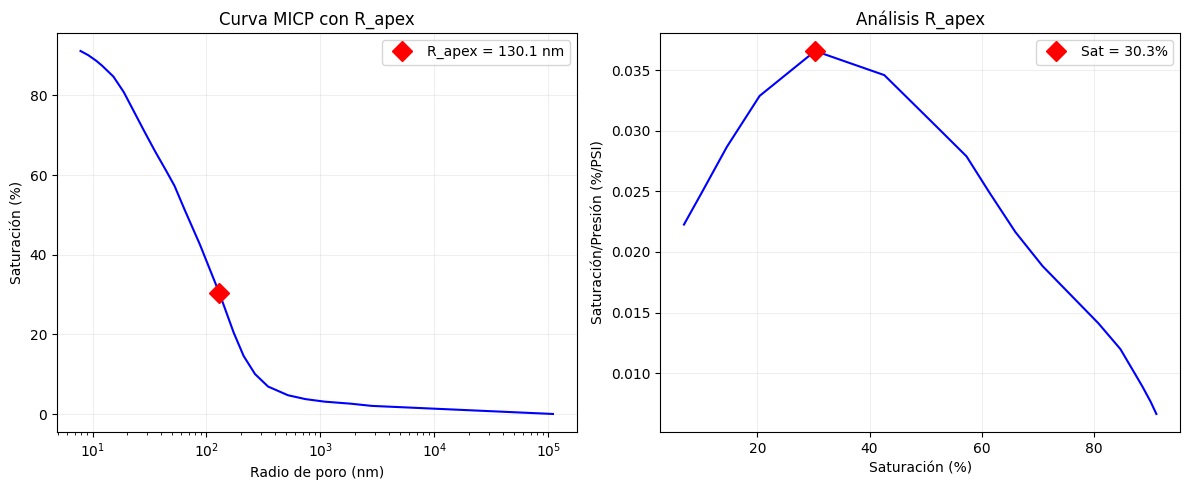

In [56]:
def graficar_analisis_rapex(df, sat_min=5.0, gamma=0.485, theta=140):
    """
    Grafica el análisis de R_apex de manera independiente.

    Args:
        df (pd.DataFrame): DataFrame con los datos de MICP
        sat_min (float): Saturación mínima a considerar (%)
        gamma (float): Tensión superficial del mercurio (N/m)
        theta (float): Ángulo de contacto (grados)
    """
    # Crear la figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Filtrar datos por saturación mínima
    df_apex = df[df['Saturación (%)'] >= sat_min].copy()

    # Calcular la relación saturación/presión
    df_apex['Sat_Pressure_Ratio'] = df_apex['Saturación (%)'] / df_apex['Presión (PSI)']

    # Encontrar el punto máximo
    idx_max = df_apex['Sat_Pressure_Ratio'].idxmax()
    presion_apex = df_apex.loc[idx_max, 'Presión (PSI)']
    saturacion_apex = df_apex.loc[idx_max, 'Saturación (%)']
    ratio_max = df_apex.loc[idx_max, 'Sat_Pressure_Ratio']

    # Calcular R_apex
    presion_pa = presion_apex * 6894.76  # Convertir PSI a Pa
    theta_rad = np.radians(theta)
    r_apex = -2 * gamma * np.cos(theta_rad) / presion_pa
    r_apex_nm = r_apex * 1e9

    # Graficar curva MICP
    ax1.semilogx(df['Radio de poro (nm)'], df['Saturación (%)'], '-b')
    ax1.plot(r_apex_nm, saturacion_apex, 'rD', markersize=10,
             label=f'R_apex = {r_apex_nm:.1f} nm')
    ax1.set_xlabel('Radio de poro (nm)')
    ax1.set_ylabel('Saturación (%)')
    ax1.set_title('Curva MICP con R_apex')
    ax1.grid(True)
    ax1.legend()

    # Graficar análisis R_apex
    ax2.plot(df_apex['Saturación (%)'], df_apex['Sat_Pressure_Ratio'], '-b')
    ax2.plot(saturacion_apex, ratio_max, 'rD', markersize=10,
             label=f'Sat = {saturacion_apex:.1f}%')
    ax2.set_xlabel('Saturación (%)')
    ax2.set_ylabel('Saturación/Presión (%/PSI)')
    ax2.set_title('Análisis R_apex')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()

    # Imprimir resultados
    print(f"Resultados del análisis R_apex:")
    print(f"R_apex: {r_apex_nm:.2f} nm")
    print(f"Saturación en R_apex: {saturacion_apex:.2f}%")
    print(f"Presión en R_apex: {presion_apex:.2f} PSI")

    return fig, r_apex_nm, saturacion_apex

# Ejemplo de uso:
# graficar_analisis_rapex(df, sat_min=5.0)
#df = pd.read_excel('datos_intrusion_mercurio_ts_23.xlsx')

# Realizar el análisis
fig, r_apex, sat_apex = graficar_analisis_rapex(df1, sat_min=5.0)

# Guardar la figura si lo deseas
fig.savefig('analisis_rapex.png', dpi=300, bbox_inches='tight')

plt.show()